# Periodic Table

In [1]:
import pandas as pd
import numpy as np

from plotnine import (
    ggplot,
    aes,
    geom_tile,
    geom_text,
    scale_y_reverse,
    scale_y_discrete,
    scale_fill_brewer,
    scale_color_manual,
    coord_equal,
    theme,
    theme_void,
    element_blank,
    element_rect,
    element_text,
)

*Graphing of highly organised tabular information*

Read the data.

In [2]:
elements = pd.read_csv("data/elements.csv")
elements.head()

5 rows × 21 columns

Alter the data types of the information that will be plotted. This makes
it convenient to work with.

In [3]:
elements["group"] = [-1 if g == "-" else int(g) for g in elements.group]
elements["bonding type"] = elements["bonding type"].astype("category")
elements["metal"] = elements["metal"].astype("category")
elements["atomic_number"] = elements["atomic number"].astype(str)

The periodic table has two tables, a `top` and `bottom`. The elements in
the `top` have groups, and those in the `bottom` have no groups. We make
separate dataframes for both – they have different alignments.

In [4]:
top = elements.query("group != -1").copy()
bottom = elements.query("group == -1").copy()

The `top` table is nice and well behaving. The `x` location of the
elements indicate the group and the `y` locations the period.

In [5]:
top["x"] = top.group
top["y"] = top.period

The `bottom` table has 2 rows, with the `atomic number` increasing to
the right. We create an `x` based on the `atomic number` and add a
`horizontal shift`. As the dataframe is ordered by `atomic number`, the
operation is easier. The `bottom` elements are labelled with a “period”.
We add a vertical shift to give us a good `y` location that gives the
appearance of two tables.

In [6]:
nrows = 2
hshift = 3.5
vshift = 3
bottom["x"] = np.tile(np.arange(len(bottom) // nrows), nrows) + hshift
bottom["y"] = bottom.period + vshift

We will be plotting using tiles and we want to have some space between
the tiles. We have set the `x` and `y` locations above to take up a unit
of space. To get a good effect, the tile dimensions should be less than
1.

In [7]:
tile_width = 0.95
tile_height = 0.95

First peak

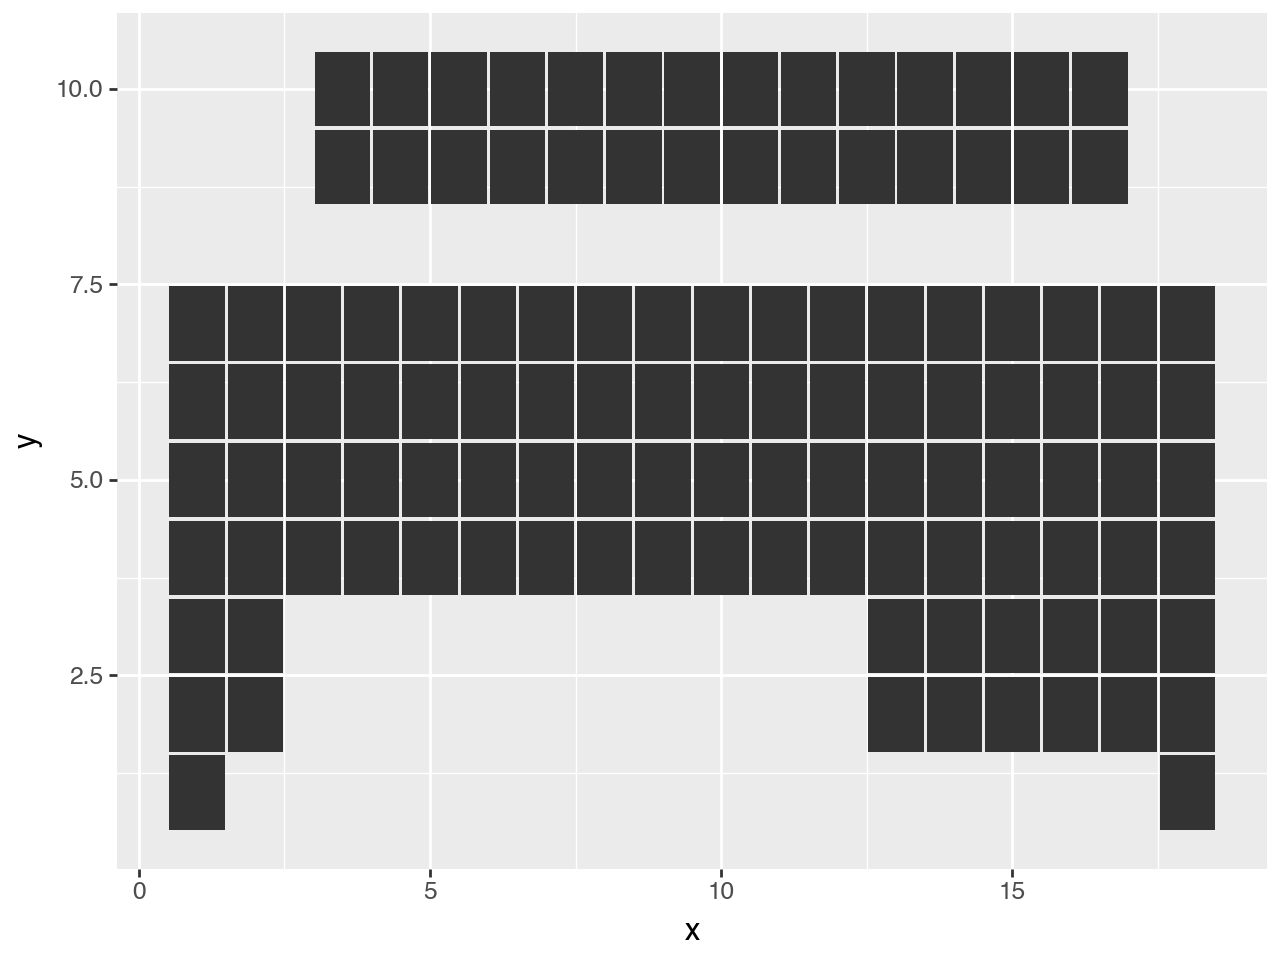

In [8]:
(
    ggplot(aes("x", "y"))
    + geom_tile(top, aes(width=tile_width, height=tile_height))
    + geom_tile(bottom, aes(width=tile_width, height=tile_height))
)

The table upside down. We could have been more careful when creating the
`y` locations since the periods are drawn in descending order. But, we
can fix that with a `reverse` scale.

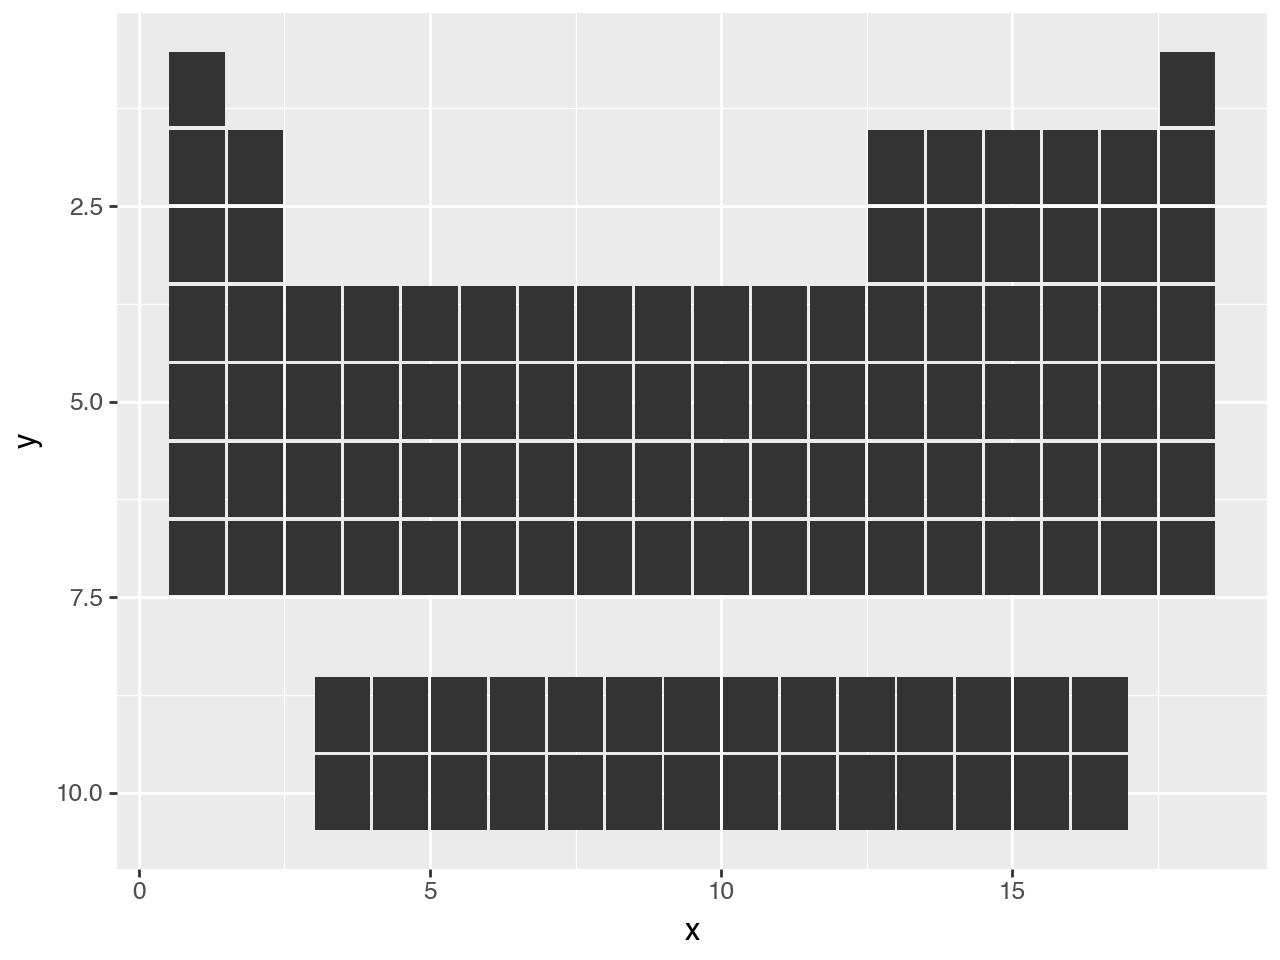

In [9]:
(
    ggplot(aes("x", "y"))
    + geom_tile(top, aes(width=tile_width, height=tile_height))
    + geom_tile(bottom, aes(width=tile_width, height=tile_height))
    + scale_y_reverse()  # new
)

Let us apply some color to it.

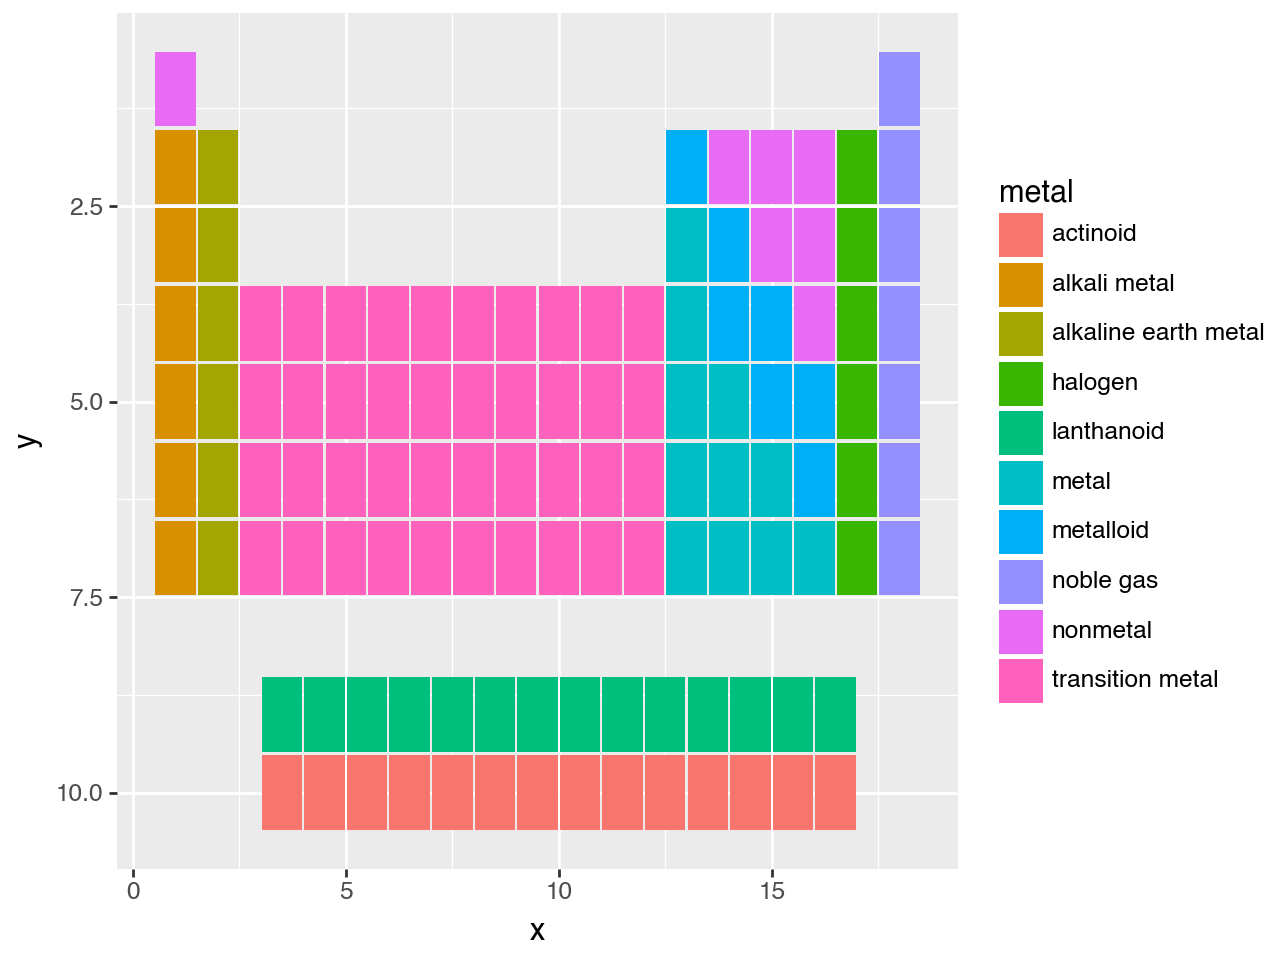

In [10]:
(
    ggplot(aes("x", "y"))
    + aes(fill="metal")  # new
    + geom_tile(top, aes(width=tile_width, height=tile_height))
    + geom_tile(bottom, aes(width=tile_width, height=tile_height))
    + scale_y_reverse()
)

#### Now for some trick

Goal: To add text to the tiles

There are four pieces of text that we shall add to the tiles, that is 4
`geom_text` additions. As we have two tables, that comes to 8
`geom_text` additions. When any `geom` is added to a `ggplot` object,
behind the scenes a layer is created and added. We can create a group of
layers that can be added to a `ggplot` object in one go using a list.

We use a function that accepts a dataframe, and returns a list of geoms.

In [11]:
def inner_text(data):
    layers = [
        geom_text(
            data,
            aes(label="atomic_number"),
            nudge_x=-0.40,
            nudge_y=0.40,
            ha="left",
            va="top",
            fontweight="normal",
            size=6,
        ),
        geom_text(data, aes(label="symbol"), nudge_y=0.1, size=9),
        geom_text(
            data, aes(label="name"), nudge_y=-0.125, fontweight="normal", size=4.5
        ),
        geom_text(
            data, aes(label="atomic mass"), nudge_y=-0.3, fontweight="normal", size=4.5
        ),
    ]
    return layers

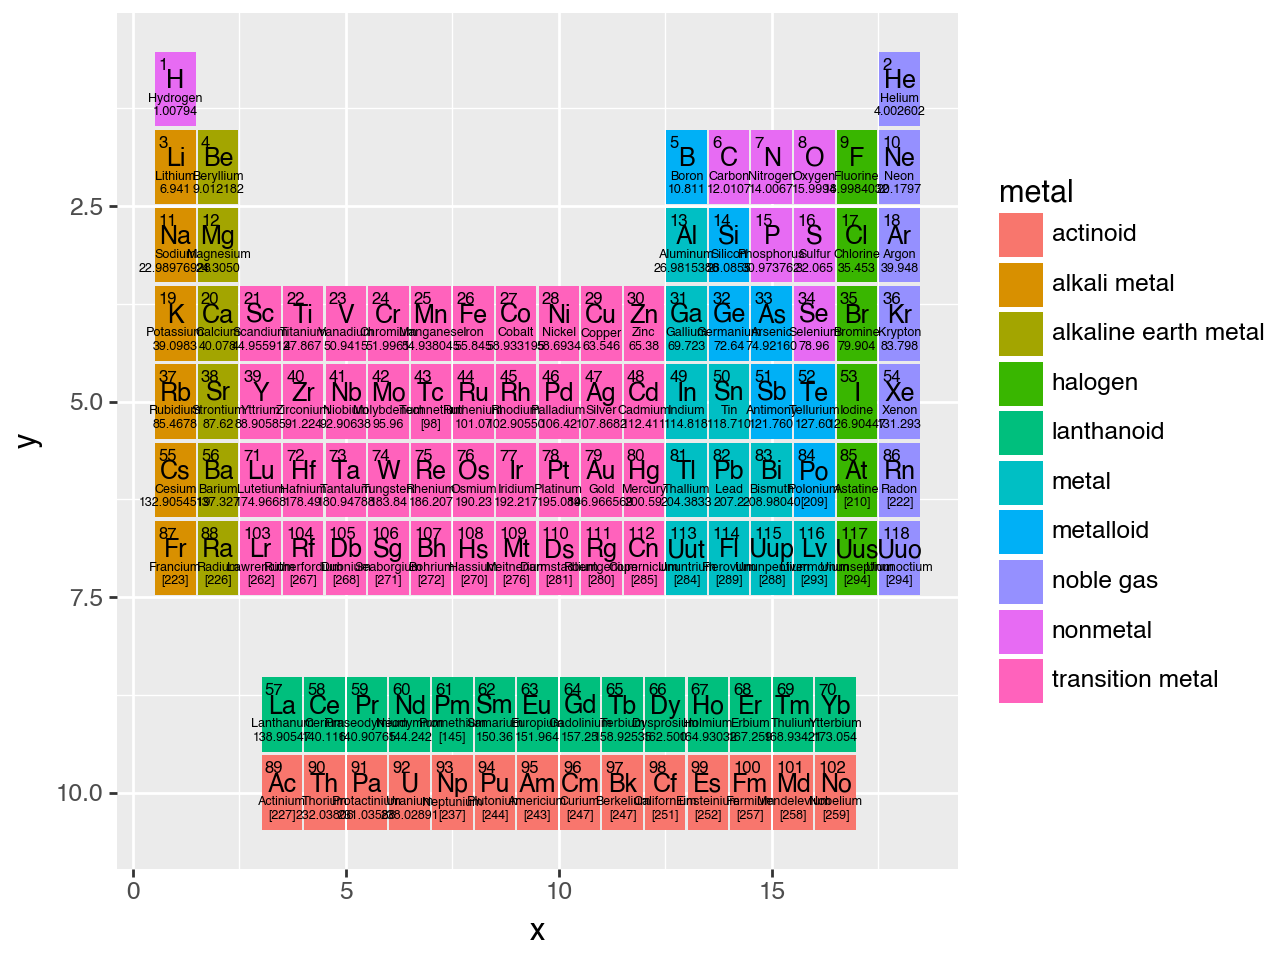

In [12]:
(
    ggplot(aes("x", "y"))
    + aes(fill="metal")
    + geom_tile(top, aes(width=tile_width, height=tile_height))
    + geom_tile(bottom, aes(width=tile_width, height=tile_height))
    + inner_text(top)  # new
    + inner_text(bottom)  # new
    + scale_y_reverse()
)

It is crowded in there and the tiles do not have equal dimentions. Use
the `theme` create a larger figure. `coord_equal` give us equal units
along the axes, this makes the tiles square.

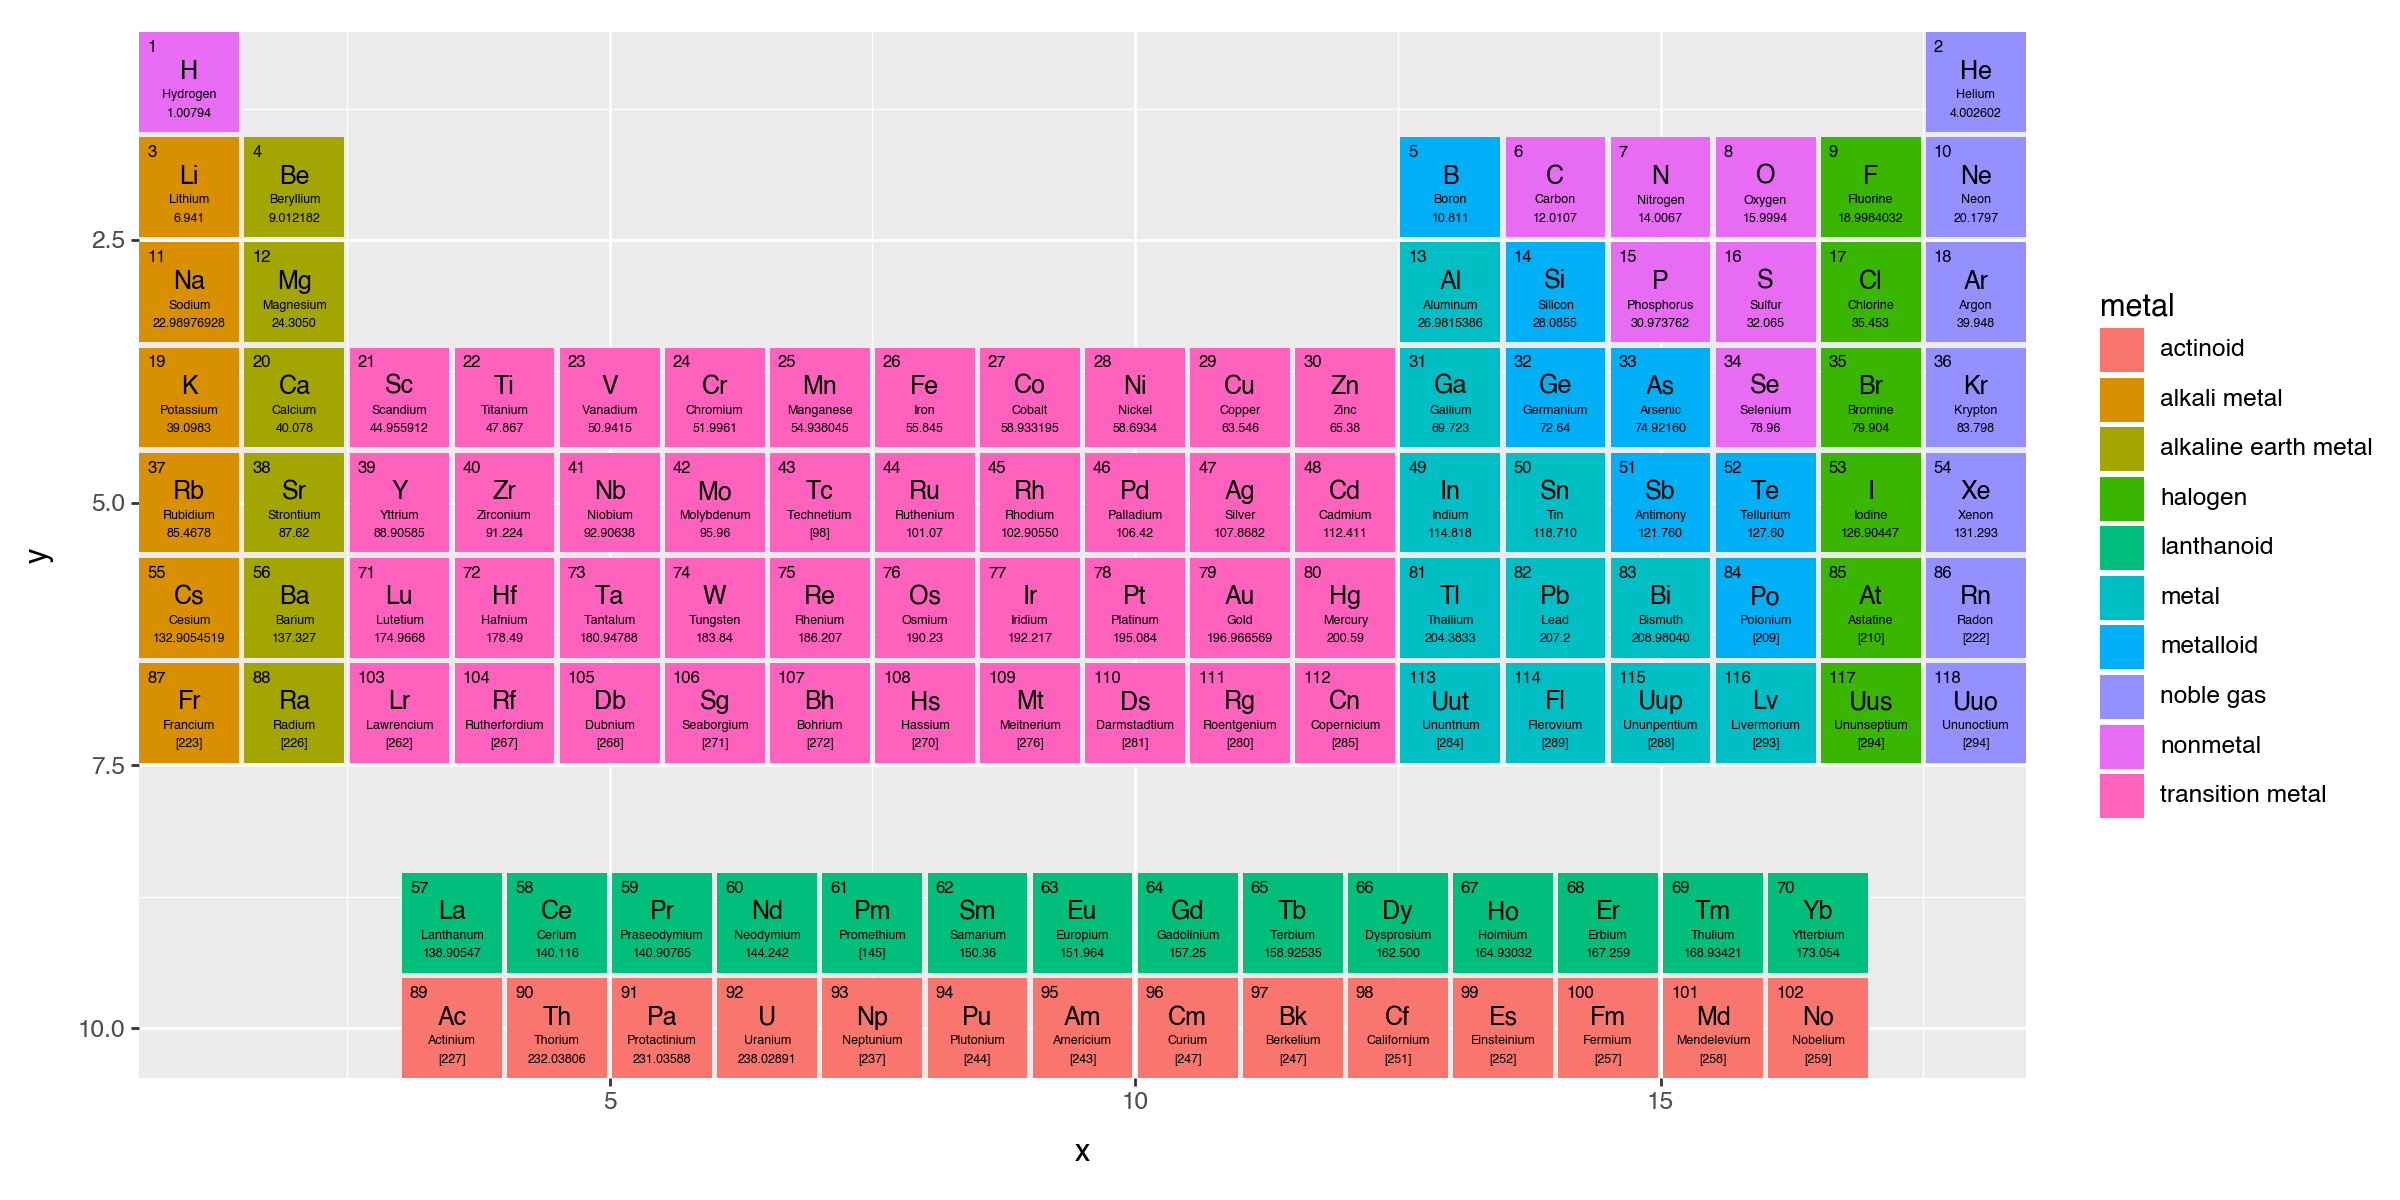

In [13]:
(
    ggplot(aes("x", "y"))
    + aes(fill="metal")
    + geom_tile(top, aes(width=tile_width, height=tile_height))
    + geom_tile(bottom, aes(width=tile_width, height=tile_height))
    + inner_text(top)
    + inner_text(bottom)
    + scale_y_reverse()
    + coord_equal(expand=False)  # new
    + theme(figure_size=(12, 6))  # new
)

It is has all the information we want, except one for complication.
Elements `Lu` and `Lr` also belong in the bottom table. One way to show
this duality is to have tiles with two colors split horizontally.

The colors are determined by the `metal` field, and we know the `x` and
`y` locations. We create a dataframe with this information to create a
half-tile. A half-tile is centered at the quarter mark.

In [14]:
split_df = pd.DataFrame(
    {
        "x": 3 - tile_width / 4,
        "y": [6, 7],
        "metal": pd.Categorical(["lanthanoid", "actinoid"]),
    }
)

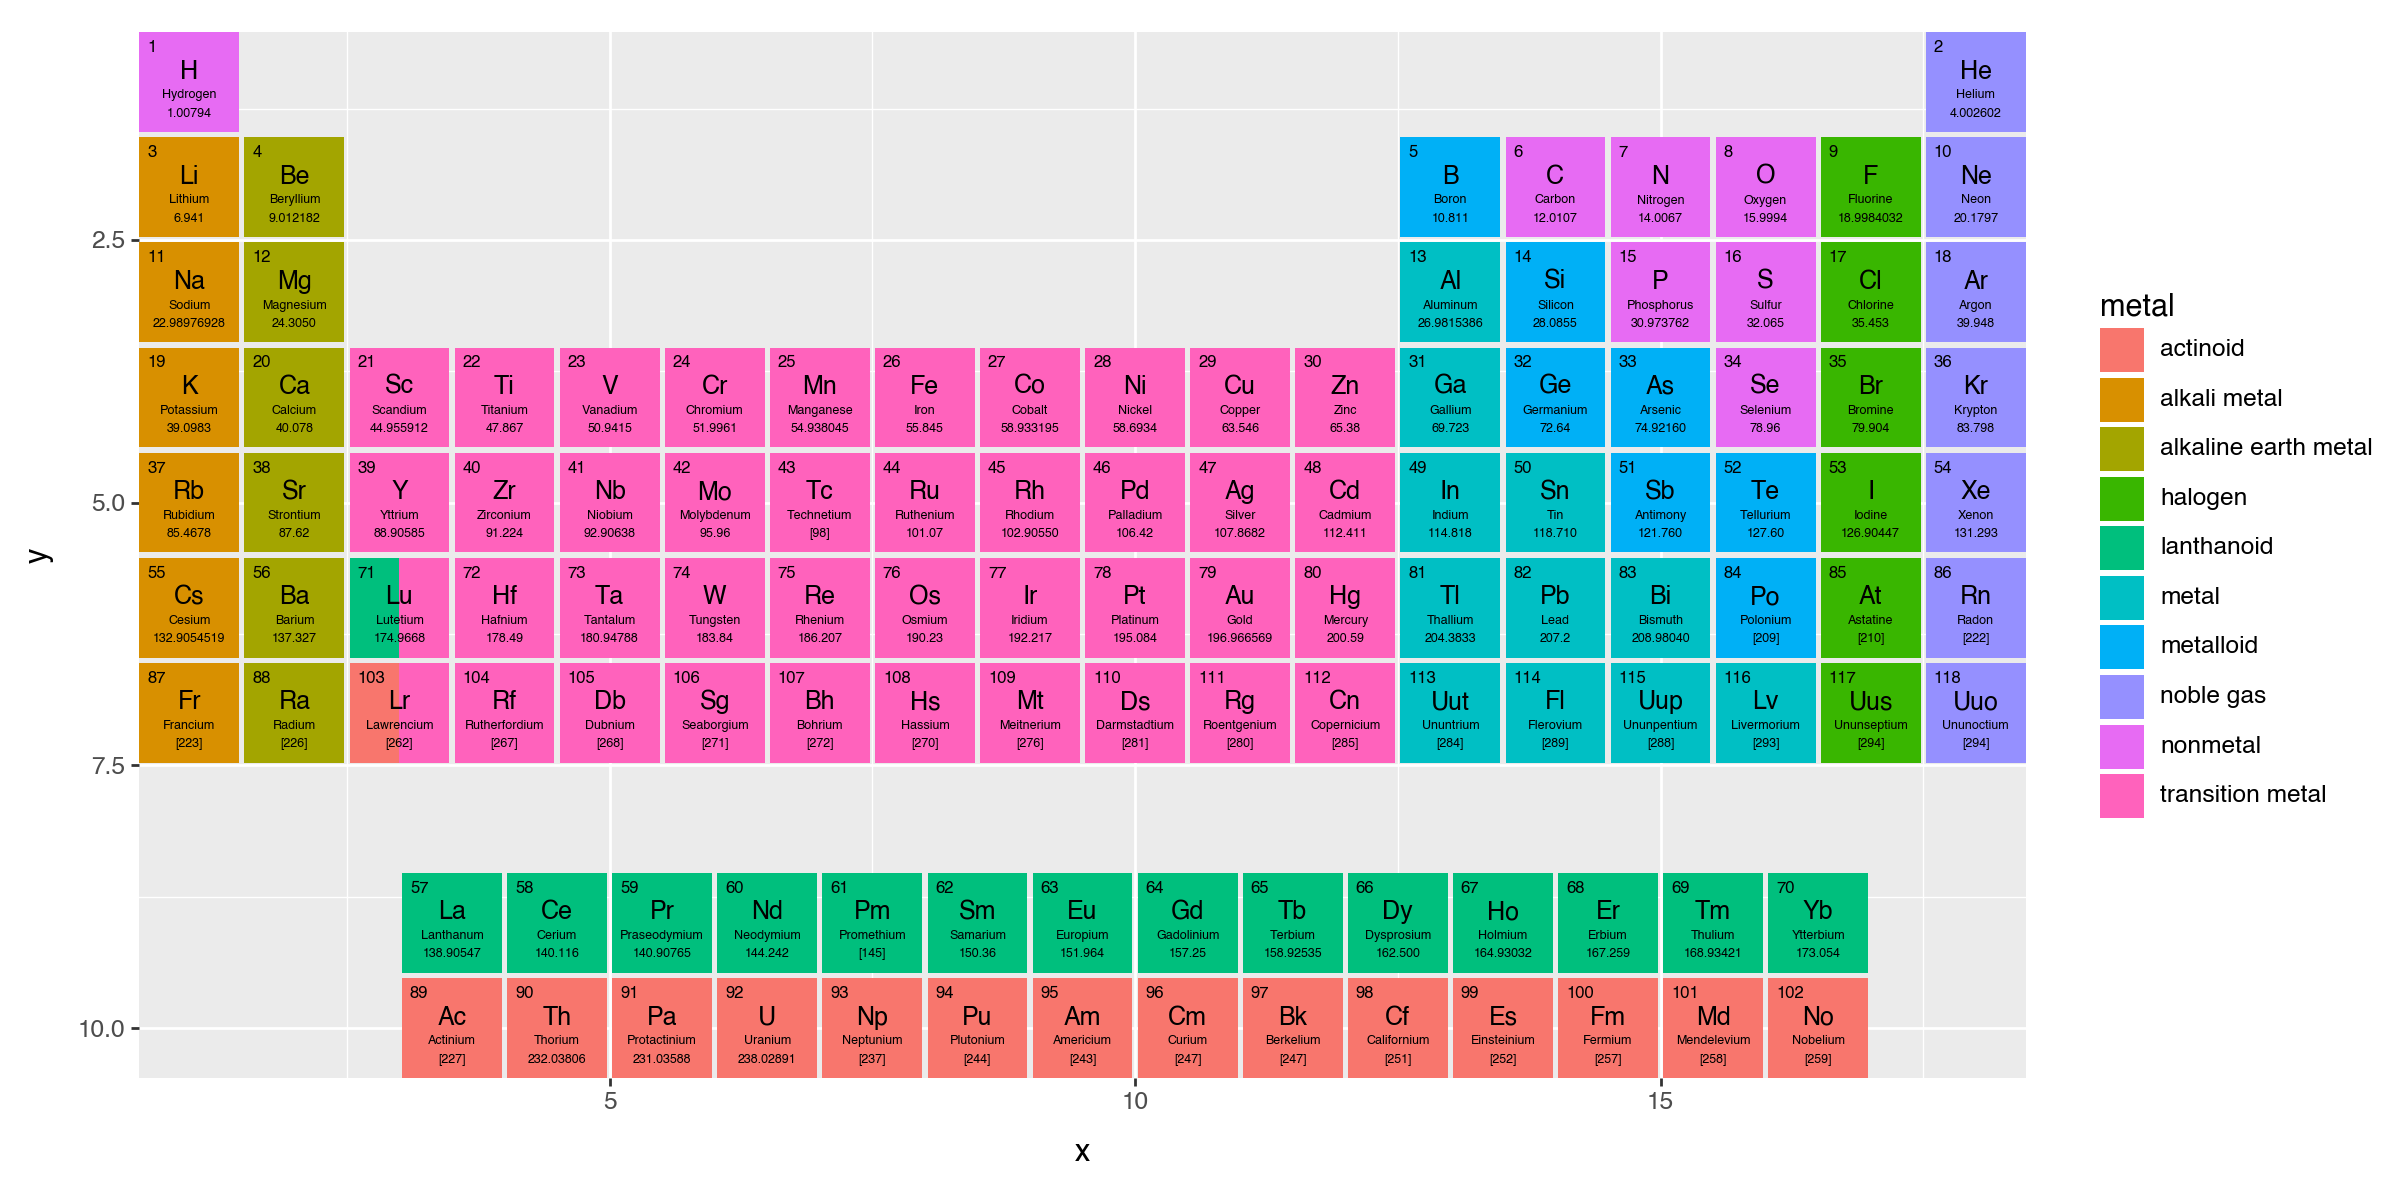

In [15]:
(
    ggplot(aes("x", "y"))
    + aes(fill="metal")
    + geom_tile(top, aes(width=tile_width, height=tile_height))
    + geom_tile(split_df, aes(width=tile_width / 2, height=tile_height))  # new
    + geom_tile(bottom, aes(width=tile_width, height=tile_height))
    + inner_text(top)
    + inner_text(bottom)
    + scale_y_reverse()
    + coord_equal(expand=False)
    + theme(figure_size=(12, 6))
)

Change the `fill` color for a different look and use a `theme` that
clears out all the clutter.

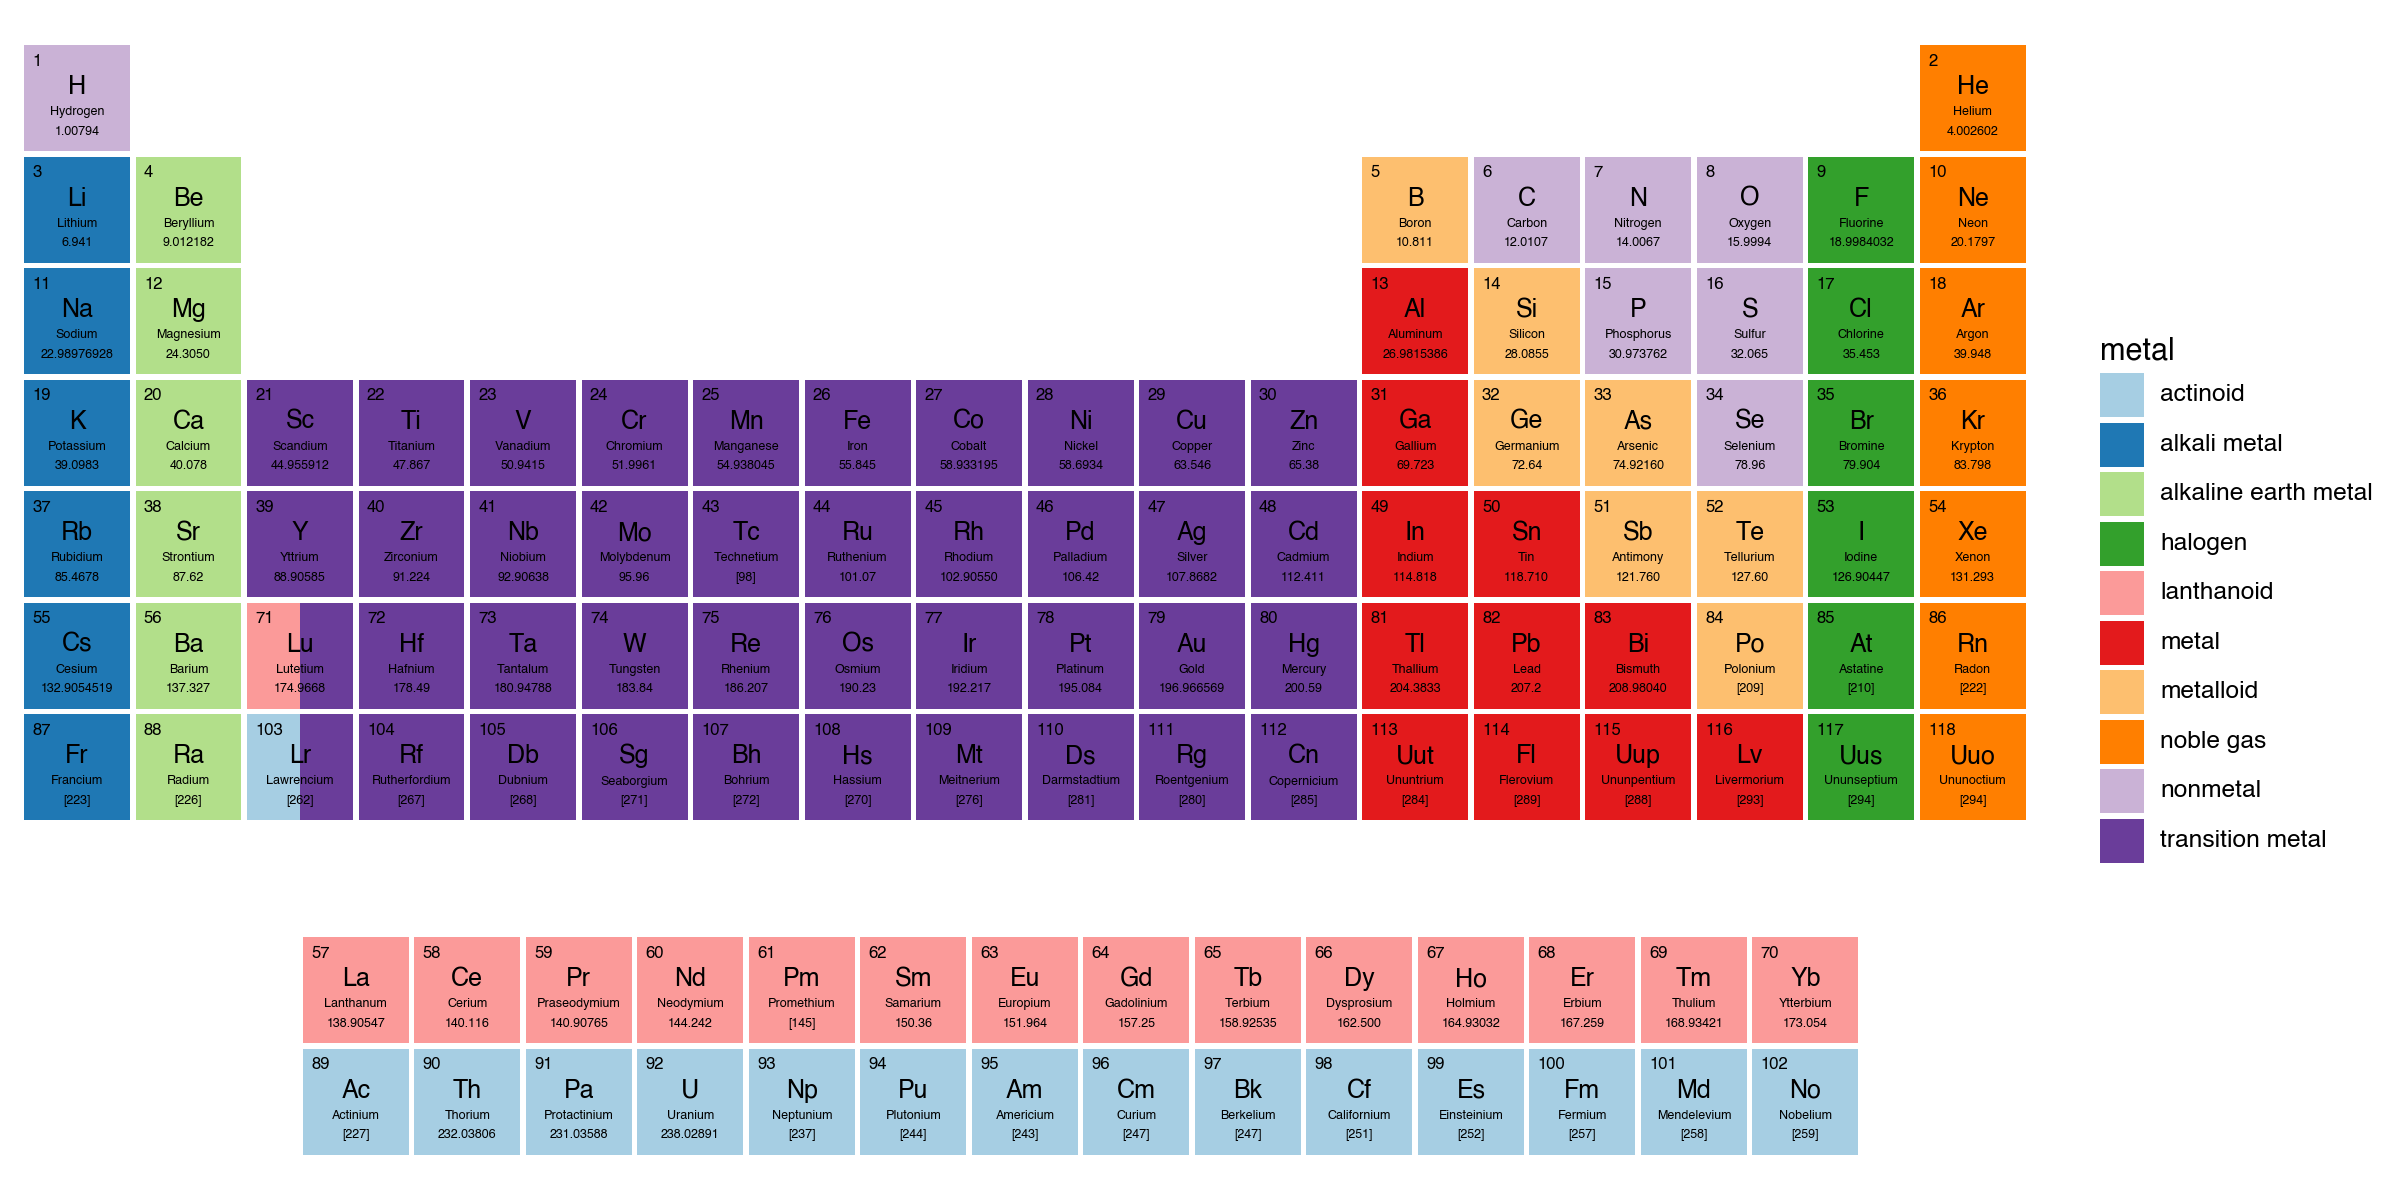

In [16]:
from plotnine import guides
(
    ggplot(aes("x", "y"))
    + aes(fill="metal")
    + geom_tile(top, aes(width=tile_width, height=tile_height))
    + geom_tile(split_df, aes(width=tile_width / 2, height=tile_height))
    + geom_tile(bottom, aes(width=tile_width, height=tile_height))
    + inner_text(top)
    + inner_text(bottom)
    + scale_y_reverse()
    + scale_fill_brewer(type="qual", palette=3)  # new
    + coord_equal(expand=False)
    + theme_void()  # new
    + theme(
        figure_size=(12, 6),
        plot_margin_left=0.01,
        plot_margin_right=0.01,
        plot_background=element_rect(fill="white"),
    )  # new
)

Add the group number along the top most row of each column, and period
number along the left side of the top table.

For the period number, we set the `breaks` on the `y scale`.

In [17]:
# The location of the group number is the top most (and therefore smallest period)
# element with the group
groupdf = top.groupby("group").agg(y=("period", "min")).reset_index()

Finally,

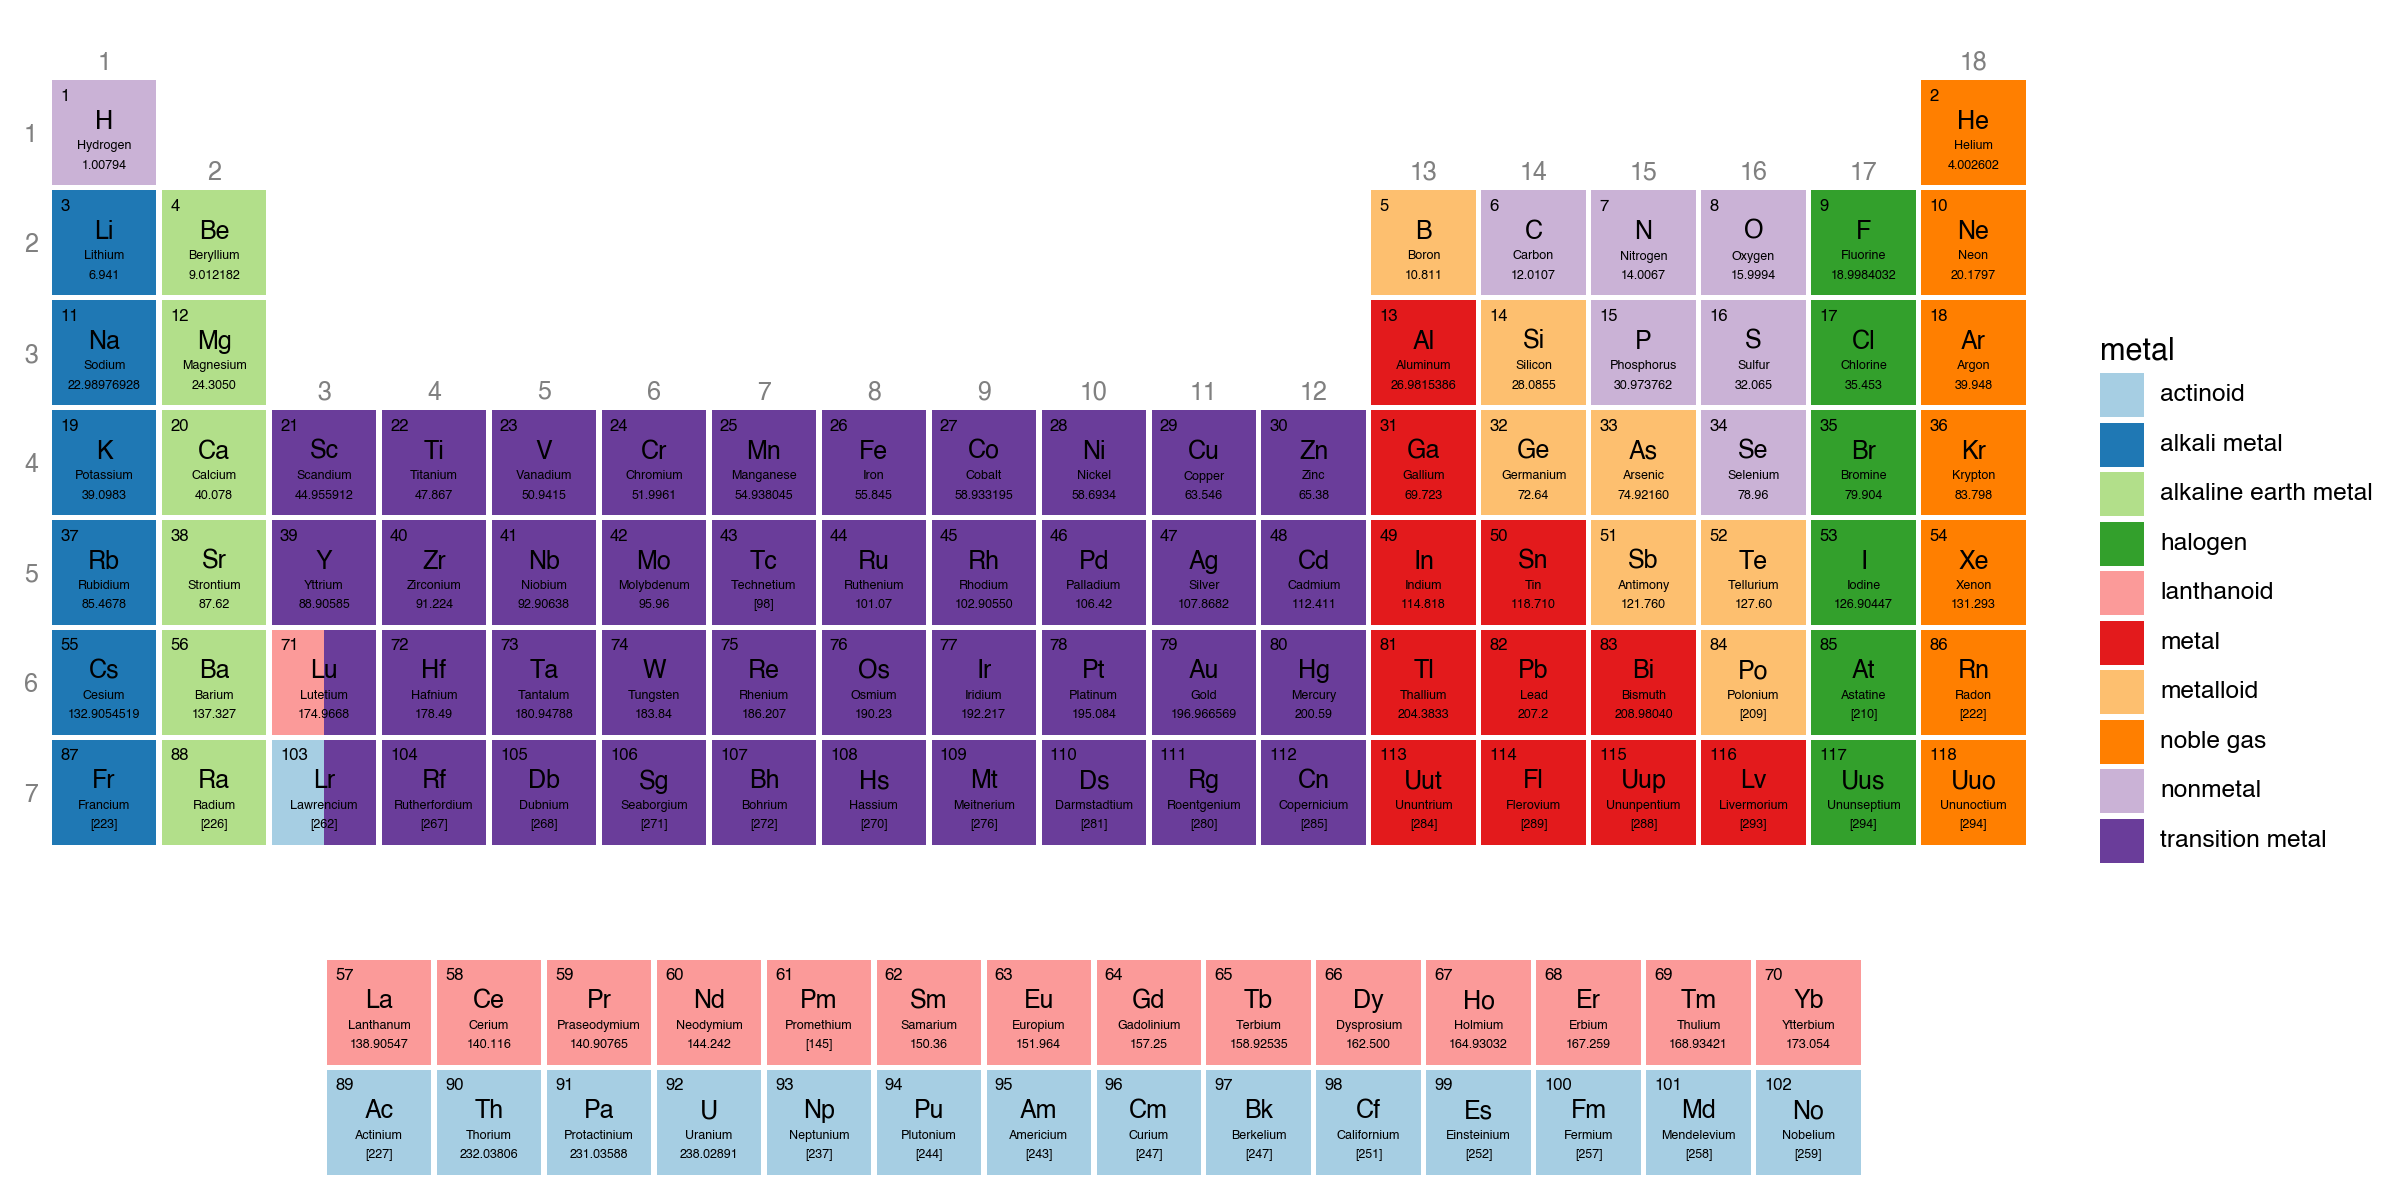

In [18]:
# Gallery, tiles

(
    ggplot(aes("x", "y"))
    + aes(fill="metal")
    + geom_tile(top, aes(width=tile_width, height=tile_height))
    + geom_tile(split_df, aes(width=tile_width / 2, height=tile_height))
    + geom_tile(bottom, aes(width=tile_width, height=tile_height))
    + inner_text(top)
    + inner_text(bottom)
    + geom_text(
        groupdf,
        aes("group", "y", label="group"),
        color="gray",
        nudge_y=0.525,
        va="bottom",
        fontweight="normal",
        size=9,
        inherit_aes=False,
    )  # new
    + scale_y_reverse(breaks=range(1, 8), limits=(0, 10.5))  # modified
    + scale_fill_brewer(type="qual", palette=3)
    + coord_equal(expand=False)
    + theme_void()
    + theme(
        figure_size=(12, 6),
        plot_margin_left=0.01,
        plot_margin_right=0.01,
        plot_background=element_rect(fill="white"),
        axis_text_y=element_text(margin={"r": 5}, color="gray", size=9),  # new
    )
)

What we could have done different:

1.  After we set the `x` and `y` positions in th the `top` and `bottom`
    dataframes, we could have concatenated them back together. Then,
    that `Layers` trick would not save us much.

**Pro tip**: Save the plot as a pdf.

### Annotated Heatmap

*Conditinous data recorded at discrete time intervals over many cycles*

Read data

In [19]:
flights = pd.read_csv("data/flights.csv")
months = flights["month"].unique()  # Months ordered January, ..., December
flights["month"] = pd.Categorical(flights["month"], categories=months)
flights.head()

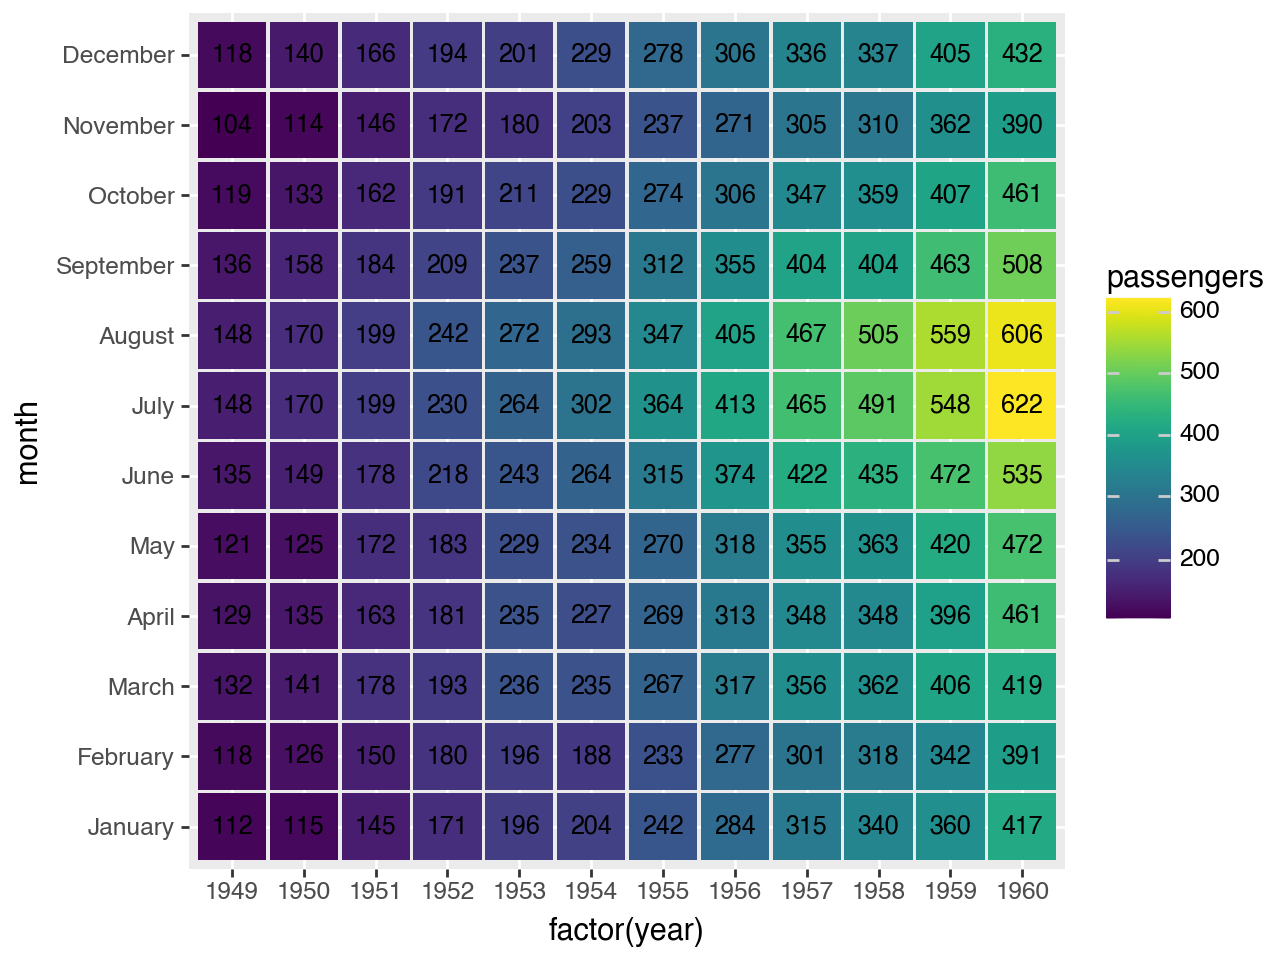

In [20]:
# We use 'factor(year)' -- a discrete -- instead of 'year' so that all the years
# are displayed along the x-axis.
# The .95s create spacing between the tiles.

(
    ggplot(flights, aes("factor(year)", "month", fill="passengers"))
    + geom_tile(aes(width=0.95, height=0.95))
    + geom_text(aes(label="passengers"), size=9)
)

That looks like what we want, but it could do with a few tweaks. First
the contrast between the tiles and the text is not good for the lower
passenger numbers. We use `pd.cut` to partition the number of passengers
into two *discrete* groups.

In [21]:
flights["p_group"] = pd.cut(
    flights["passengers"], (0, 300, 1000), labels=("low", "high")
)
flights.head()

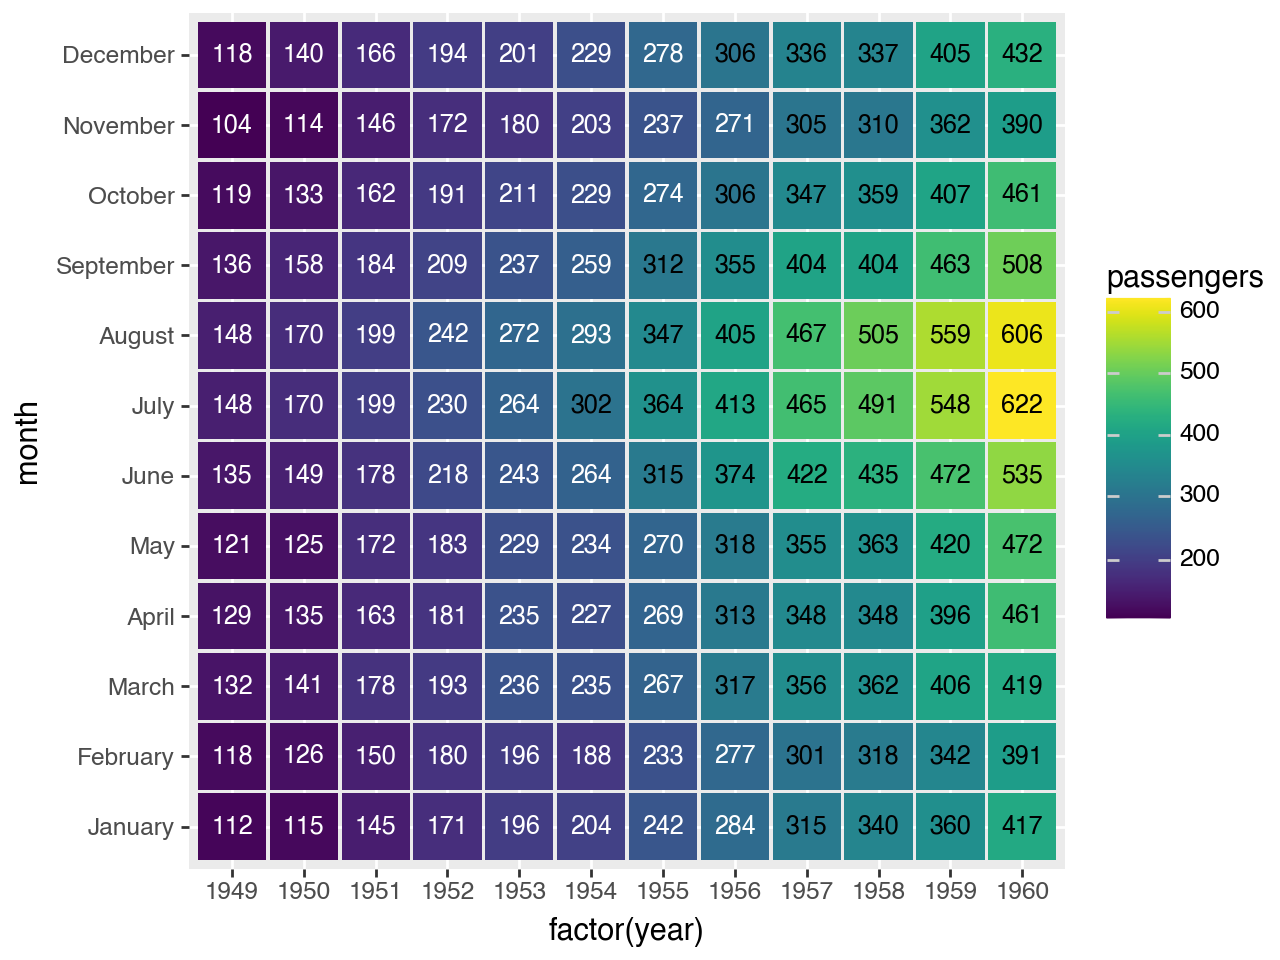

In [22]:
(
    ggplot(flights, aes("factor(year)", "month", fill="passengers"))
    + geom_tile(aes(width=0.95, height=0.95))
    + geom_text(aes(label="passengers", color="p_group"), size=9, show_legend=False)  # modified
    + scale_color_manual(["white", "black"])  # new
)

Last tweaks, put `January` at the top and remove the axis ticks and plot
background.

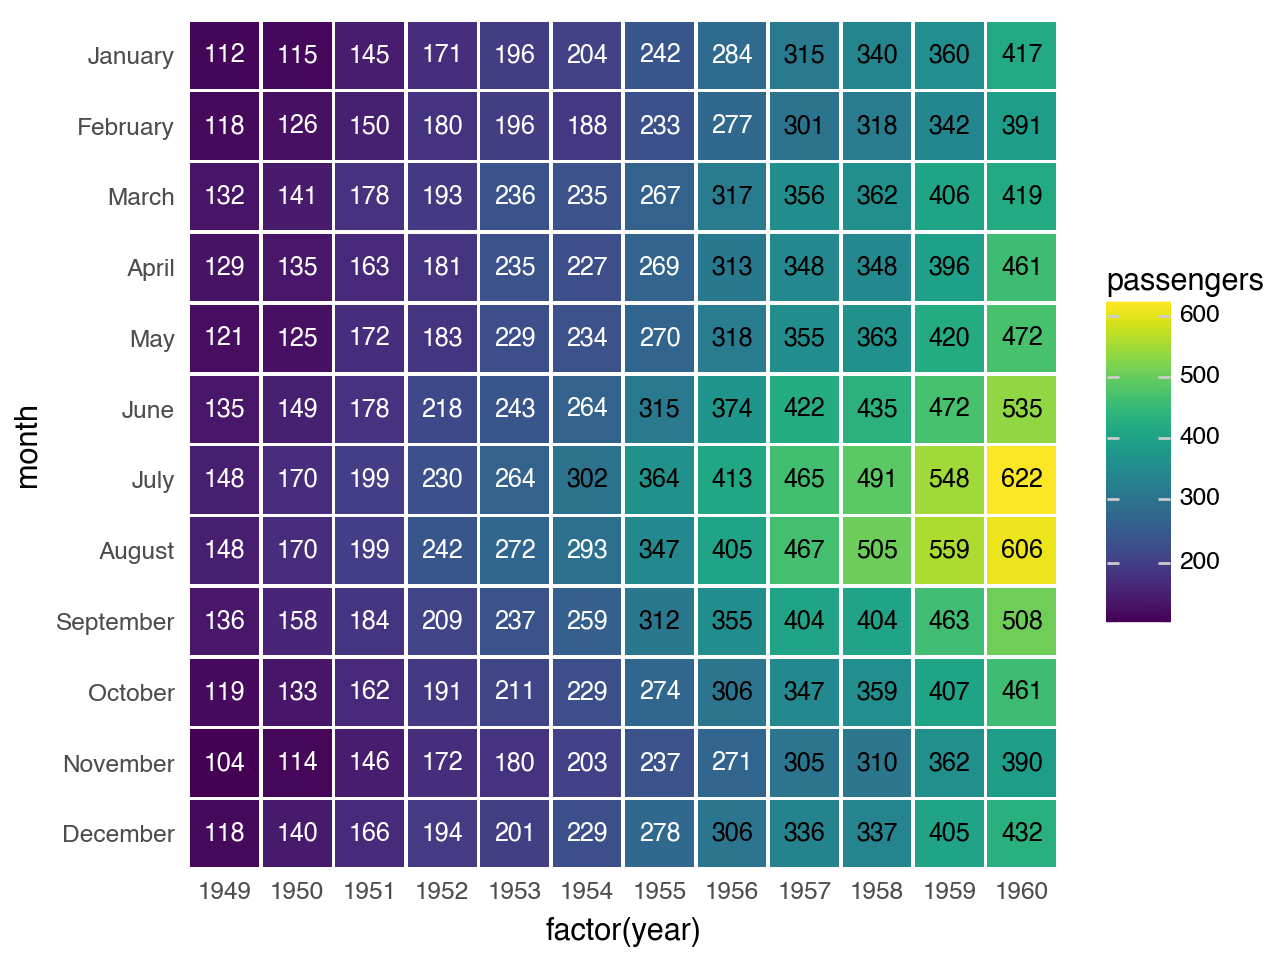

In [23]:
# Gallery, tiles

(
    ggplot(flights, aes("factor(year)", "month", fill="passengers"))
    + geom_tile(aes(width=0.95, height=0.95))
    + geom_text(aes(label="passengers", color="p_group"), size=9, show_legend=False)
    + scale_color_manual(["white", "black"])  # new
    + scale_y_discrete(limits=months[::-1])  # new
    + theme(  # new
        axis_ticks=element_blank(),
        panel_background=element_rect(fill="white"),
    )
)

You can get similar results if you replace

     + geom_tile(aes(width=.95, height=.95))
     + geom_text(aes(label='passengers', color='p_group'), size=9, show_legend=False)

with

    + geom_label(aes(label='passengers', color='p_group'), size=9, show_legend=False)

**Credit**: This example is a recreation of [this
seaborn](https://seaborn.pydata.org/examples/heatmap_annotation.html)
example.